In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Path to directories
path = '/content/drive/MyDrive/TFM - Neural ODEs/Neural ODE/df.csv'

# Read data
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(path, sep=',', index_col='datetime', parse_dates=['datetime'], date_parser=date_parser)
df.head()

Mounted at /content/drive


<ipython-input-2-f9765ec2bc53>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')


,demand,wind,price,day_of_week
datetime,,,,
2018-01-01 00:00:00,22718.1,11487.7,6.74,7
2018-01-01 01:00:00,21510.8,10123.2,4.74,7
2018-01-01 02:00:00,19865.8,8763.5,3.66,7
2018-01-01 03:00:00,19248.3,5661.2,2.30,7
2018-01-01 04:00:00,18632.1,5689.0,2.30,7


In [3]:
df

,demand,wind,price,day_of_week
datetime,,,,
2018-01-01 00:00:00,22718.100,11487.700,6.74,7
2018-01-01 01:00:00,21510.800,10123.200,4.74,7
2018-01-01 02:00:00,19865.800,8763.500,3.66,7
2018-01-01 03:00:00,19248.300,5661.200,2.30,7
2018-01-01 04:00:00,18632.100,5689.000,2.30,7
...,...,...,...,...
2022-12-31 19:00:00,26759.925,10060.700,18.11,5
2022-12-31 20:00:00,26306.833,9969.200,7.60,5
2022-12-31 21:00:00,24932.300,9.307,3.69,5


In [4]:
# Training set: From Wednesday to Wednesday. 14 months
train_df = df.loc['2018-03-07 00:00':'2019-04-24 23:00']
train_spot = train_df.values
train_df

,demand,wind,price,day_of_week
datetime,,,,
2018-03-07 00:00:00,27975.8,9443.8,41.83,2
2018-03-07 01:00:00,26033.7,9773.2,39.80,2
2018-03-07 02:00:00,24525.2,9876.3,37.81,2
2018-03-07 03:00:00,24230.8,9864.1,37.61,2
2018-03-07 04:00:00,24044.6,9369.3,37.54,2
...,...,...,...,...
2019-04-24 19:00:00,30490.3,14519.4,39.45,2
2019-04-24 20:00:00,31700.7,14414.6,42.08,2
2019-04-24 21:00:00,33190.0,14108.6,49.59,2


             demand          wind        price  day_of_week
count   9936.000000   9936.000000  9936.000000  9936.000000
mean   28772.315142   5658.909068    57.211088     3.183575
std     4564.699010   3257.802746    12.193980     2.256638
min    17994.300000    240.800000     0.000000     0.000000
25%    24885.250000   3122.725000    51.007500     1.000000
50%    28994.400000   5038.700000    59.190000     3.000000
75%    32459.950000   7583.950000    65.690000     5.000000
max    40094.800000  16952.600000    84.130000    12.000000


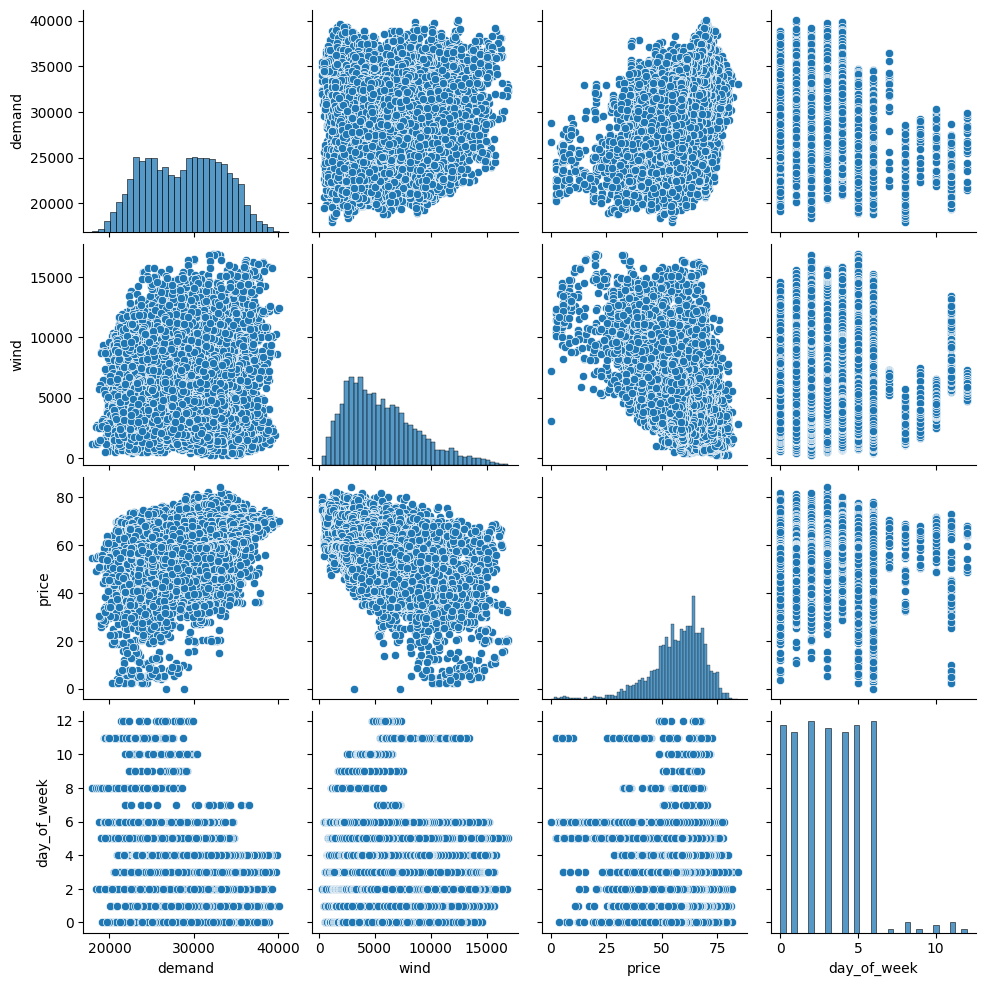

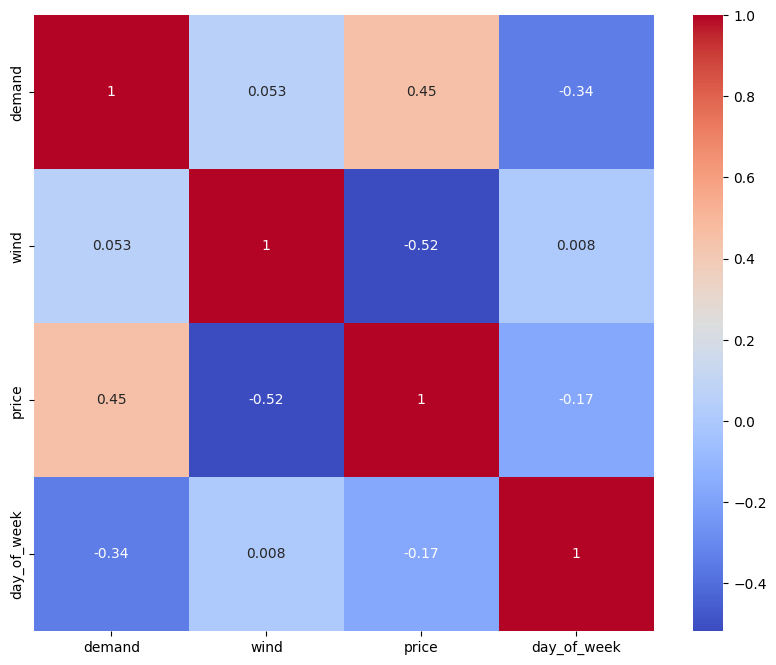

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


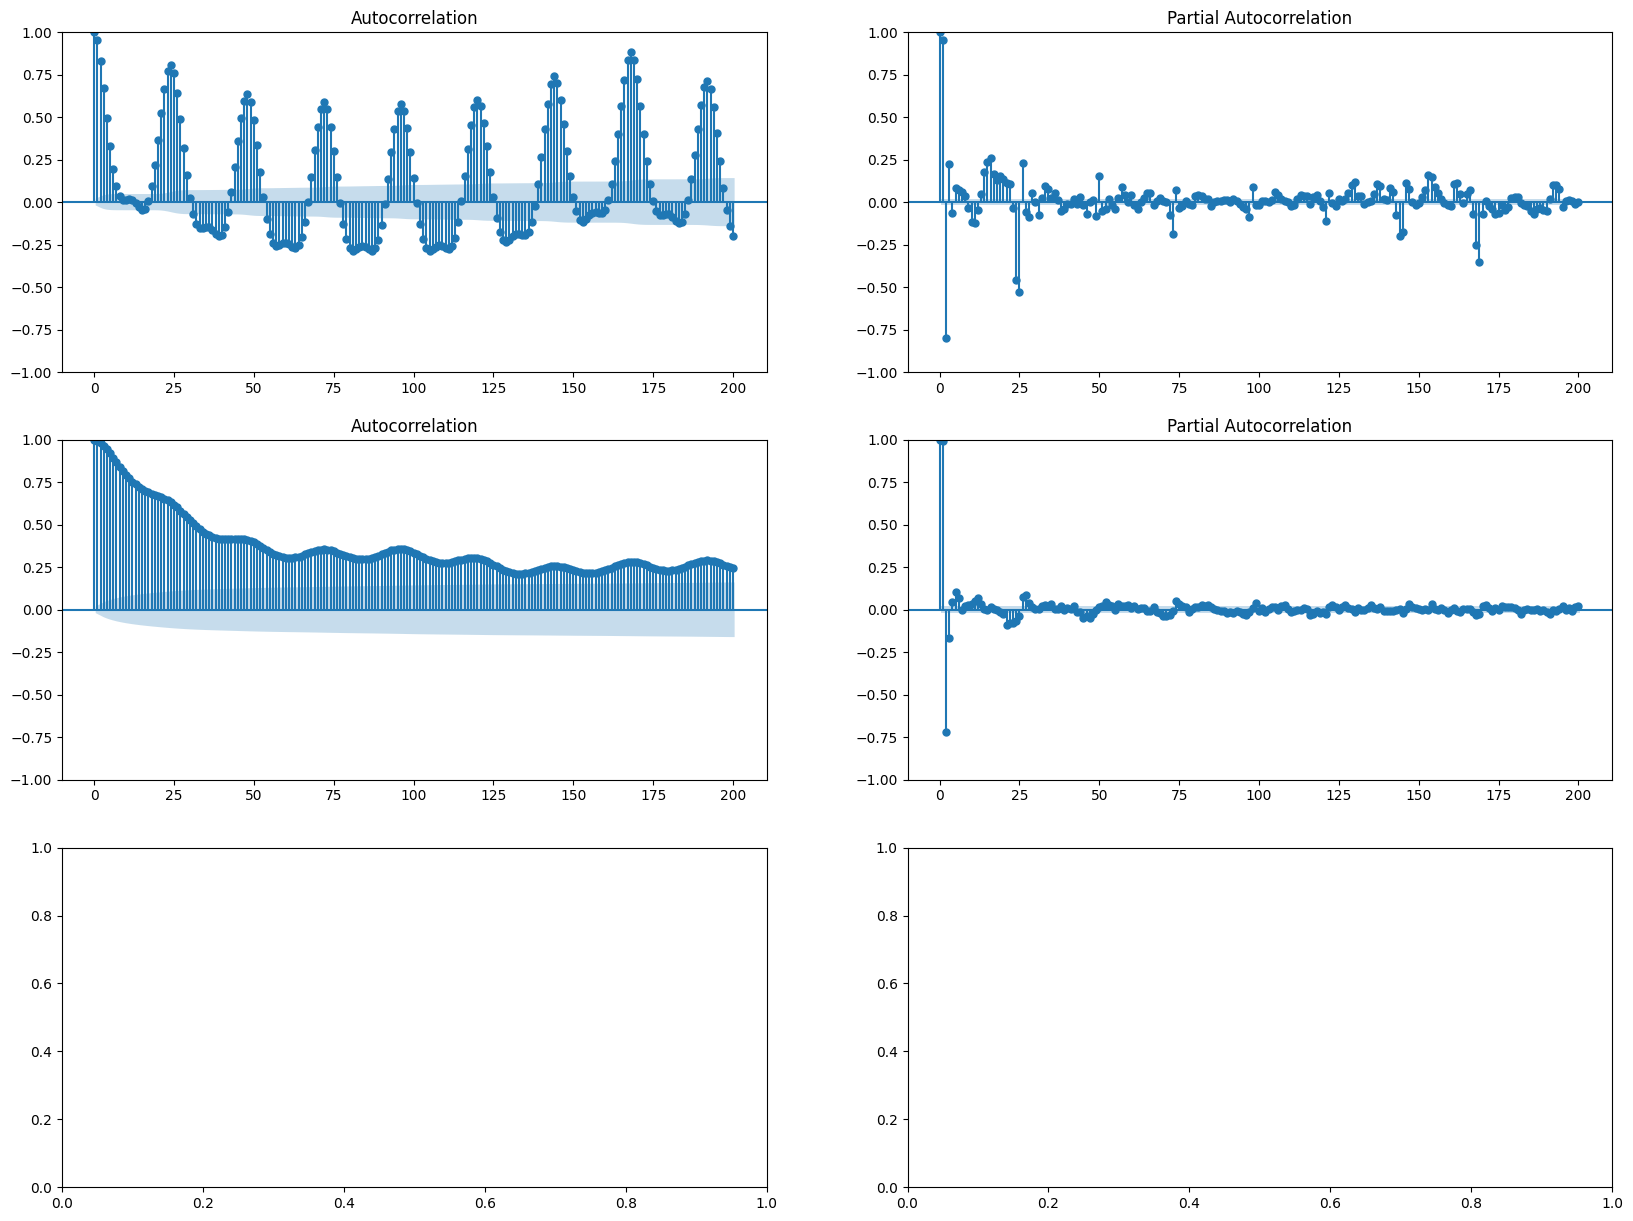

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Descriptive statistics
print(train_df.describe())

# Pairplot
sns.pairplot(train_df)
plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(10,8))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm')
plt.show()

# Time series: ACF and PACF
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

# for 'demand'
plot_acf(train_df['demand'], lags=200, ax=axs[0, 0])
plot_pacf(train_df['demand'], lags=200, ax=axs[0, 1])

# for 'wind_generation'
plot_acf(train_df['wind'], lags=200, ax=axs[1, 0])
plot_pacf(train_df['wind'], lags=200, ax=axs[1, 1])

plt.show()

In [6]:
# Validation set. 3 months
validation_df = df.loc['2019-05-01 00:00':'2019-07-31 23:00']
validation_spot = validation_df.values
validation_df

,demand,wind,price,day_of_week
datetime,,,,
2019-05-01 00:00:00,24352.5,4331.5,57.63,9
2019-05-01 01:00:00,22528.2,4177.0,56.56,9
2019-05-01 02:00:00,21539.7,3827.5,55.52,9
2019-05-01 03:00:00,20754.9,3580.3,55.71,9
2019-05-01 04:00:00,20548.3,3354.3,55.00,9
...,...,...,...,...
2019-07-31 19:00:00,31992.5,6593.2,48.79,2
2019-07-31 20:00:00,31728.5,7014.2,48.17,2
2019-07-31 21:00:00,31798.1,7277.3,48.79,2


In [7]:
# Test set: 3 months
test_df = df.loc['2019-08-07 00:00':'2019-10-30 23:00']
test_spot = test_df.values
test_df

,demand,wind,price,day_of_week
datetime,,,,
2019-08-07 00:00:00,28005.4,4676.8,49.76,2
2019-08-07 01:00:00,26047.0,4544.3,46.21,2
2019-08-07 02:00:00,25063.2,4522.2,43.51,2
2019-08-07 03:00:00,24326.0,4329.2,41.75,2
2019-08-07 04:00:00,24113.1,3897.1,42.80,2
...,...,...,...,...
2019-10-30 19:00:00,32587.8,4565.3,60.00,2
2019-10-30 20:00:00,32249.4,4990.7,56.85,2
2019-10-30 21:00:00,31105.7,5071.1,55.50,2


In [8]:
# Declaration of the scalers
scaler_demand = MinMaxScaler(feature_range=(0, 1))
scaler_wind = MinMaxScaler(feature_range=(0, 1))
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_day = MinMaxScaler(feature_range=(0, 1))

# Scalers are fitted with the training data
scaler_demand.fit(train_df[["demand"]])
scaler_wind.fit(train_df[["wind"]])
scaler_price.fit(train_df[["price"]])
scaler_day.fit(train_df[["day_of_week"]])

# Applying scalers to each column for each set
train_df.loc[:, "demand"] = scaler_demand.transform(train_df[["demand"]])
train_df.loc[:, "wind"] = scaler_wind.transform(train_df[["wind"]])
train_df.loc[:, "price"] = scaler_price.transform(train_df[["price"]])
train_df.loc[:, "day_of_week"] = scaler_day.transform(train_df[["day_of_week"]])

validation_df.loc[:, "demand"] = scaler_demand.transform(validation_df[["demand"]])
validation_df.loc[:, "wind"] = scaler_wind.transform(validation_df[["wind"]])
validation_df.loc[:, "price"] = scaler_price.transform(validation_df[["price"]])
validation_df.loc[:, "day_of_week"] = scaler_day.transform(validation_df[["day_of_week"]])

test_df.loc[:, "demand"] = scaler_demand.transform(test_df[["demand"]])
test_df.loc[:, "wind"] = scaler_wind.transform(test_df[["wind"]])
test_df.loc[:, "price"] = scaler_price.transform(test_df[["price"]])
test_df.loc[:, "day_of_week"] = scaler_day.transform(test_df[["day_of_week"]])

<ipython-input-8-7346a1cc3817>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, "demand"] = scaler_demand.transform(train_df[["demand"]])
<ipython-input-8-7346a1cc3817>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, "wind"] = scaler_wind.transform(train_df[["wind"]])
<ipython-input-8-7346a1cc3817>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [9]:
def create_windows(df, window_size=168, forecast_size=24):
    input_data, output_data = [], []

    # Step through the dataframe with a step size of 168 (7*24)
    for i in range(window_size, len(df) - forecast_size + 1, window_size):
        inputs_price = df.iloc[i-window_size:i]["price"].values
        inputs_exogenous = df.iloc[i-window_size:i+forecast_size][["demand", "wind", "day_of_week"]].values
        inputs = np.concatenate([inputs_price, inputs_exogenous.flatten()])
        outputs = df.iloc[i:i+forecast_size]["price"].values
        input_data.append(inputs)
        output_data.append(outputs)

    return np.array(input_data), np.array(output_data)

window_size = 168
forecast_size = 24

X_train, Y_train = create_windows(train_df, window_size, forecast_size)
X_validation, Y_validation = create_windows(validation_df, window_size, forecast_size)
X_test, Y_test = create_windows(test_df, window_size, forecast_size)

In [10]:
X_train.shape

(59, 744)

In [11]:
X_validation.shape

(13, 744)

In [12]:
X_test.shape

(12, 744)

In [13]:
# Converting the arrays data to PyTorch tensors and moving them to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).unsqueeze(-1).float().to(device)
Y_train_tensor = torch.tensor(Y_train).unsqueeze(-1).float().to(device)
X_train_tensor = torch.tensor(X_train).float().to(device)
Y_train_tensor = torch.tensor(Y_train).float().to(device)

X_val_tensor = torch.tensor(X_validation).unsqueeze(-1).float().to(device)
Y_val_tensor = torch.tensor(Y_validation).unsqueeze(-1).float().to(device)
X_val_tensor = torch.tensor(X_validation).float().to(device)
Y_val_tensor = torch.tensor(Y_validation).float().to(device)

In [14]:
# Model definition
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layer_neurons, output_size):
        super(MLPModel, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_layer_neurons),
            nn.BatchNorm1d(hidden_layer_neurons),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_layer_neurons, hidden_layer_neurons),
            nn.BatchNorm1d(hidden_layer_neurons),
            nn.ReLU(),
            nn.Dropout(0.1),

            # nn.Linear(hidden_layer_neurons, hidden_layer_neurons),
            # nn.BatchNorm1d(hidden_layer_neurons),
            # nn.ReLU(),
            # nn.Dropout(0.1),

            nn.Linear(hidden_layer_neurons, hidden_layer_neurons),
            nn.BatchNorm1d(hidden_layer_neurons),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_layer_neurons, output_size),
        )

    def forward(self, x):
        x = self.mlp(x)
        return x

In [15]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=100, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt') # <-- saves model to disk
        self.val_loss_min = val_loss

In [16]:
from torch.optim.lr_scheduler import LambdaLR

hidden_size = 300

# MLP model
model = MLPModel(input_size=X_train.shape[1], hidden_layer_neurons=hidden_size, output_size=24).to(device)

# Loss function: MAE
loss_fn = nn.L1Loss()

# Initialize the optimizer
LR_INICIO = 1e-1  # initial learning rate
LR_FINAL = 1e-3  # final learning rate
LR_EPOCHS = 1000  # total number of epochs
optimizer = optim.SGD(model.parameters(), lr=LR_INICIO, momentum=0.9)

# Define the learning rate scheduler
lr_lambda = lambda epoch: LR_FINAL / LR_INICIO * (LR_INICIO / LR_FINAL)**(1 - epoch / LR_EPOCHS)
scheduler = LambdaLR(optimizer, lr_lambda)

# To track loss history
loss_history = []
val_loss_history = []

# Initialize the EarlyStopping class
early_stopping = EarlyStopping(patience=300, verbose=True)

for epoch in range(3000):
    optimizer.zero_grad() # Reset gradients

    # Forward pass
    outputs = model(X_train_tensor)
    loss = loss_fn(outputs, Y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Update learning rate
    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = loss_fn(val_outputs, Y_val_tensor)

    print('Epoch [%d], Loss: %.4f, Val Loss: %.4f' % (epoch+1, loss.item(), val_loss.item()))

    # Append loss values
    loss_history.append(loss.item())
    val_loss_history.append(val_loss.item())

    # Early stopping check
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

Epoch [1], Loss: 0.7354, Val Loss: 0.5713
Validation loss decreased (inf --> 0.571252).  Saving model ...
Epoch [2], Loss: 0.6778, Val Loss: 0.5482
Validation loss decreased (0.571252 --> 0.548244).  Saving model ...
Epoch [3], Loss: 0.6539, Val Loss: 0.5145
Validation loss decreased (0.548244 --> 0.514468).  Saving model ...
Epoch [4], Loss: 0.6184, Val Loss: 0.4639
Validation loss decreased (0.514468 --> 0.463923).  Saving model ...
Epoch [5], Loss: 0.5647, Val Loss: 0.3802
Validation loss decreased (0.463923 --> 0.380243).  Saving model ...
Epoch [6], Loss: 0.4747, Val Loss: 0.2156
Validation loss decreased (0.380243 --> 0.215569).  Saving model ...
Epoch [7], Loss: 0.2989, Val Loss: 0.1957
Validation loss decreased (0.215569 --> 0.195672).  Saving model ...
Epoch [8], Loss: 0.1701, Val Loss: 0.3520
EarlyStopping counter: 1 out of 300
Epoch [9], Loss: 0.3255, Val Loss: 0.0666
Validation loss decreased (0.195672 --> 0.066596).  Saving model ...
Epoch [10], Loss: 0.0958, Val Loss: 0.1

<All keys matched successfully>

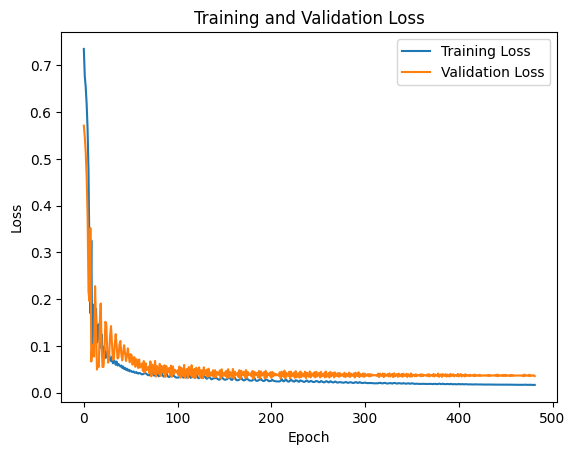

In [17]:
# Plot the loss history
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [18]:
# Model declaration
model = MLPModel(input_size=X_train.shape[1], hidden_layer_neurons=hidden_size, output_size=24)

# Loading the saved weights
model.load_state_dict(torch.load('checkpoint.pt'))

# Move the model to the appropriate device
model = model.to(device)

# Test data to a PyTorch tensor
X_test_tensor = torch.tensor(X_test).float().to(device)

# Model to evaluation mode
model.eval()

# Generating predictions on the test set
with torch.no_grad():
    test_predictions = model(X_test_tensor)

In [19]:
# Converting the predictions to a numpy array and move them back to the CPU
test_predictions_np = test_predictions.cpu().numpy()

# Empty array to hold the inverse-transformed predictions
predictions = np.empty_like(test_predictions_np)

# Inverse-transform each prediction separately
for i in range(test_predictions_np.shape[1]):
    predictions[:, i] = scaler_price.inverse_transform(test_predictions_np[:, i:i+1]).flatten()

In [20]:
# Empty array to hold the inverse-transformed labels
y_test = np.empty_like(Y_test)

# Inverse-transform each label separately
for i in range(Y_test.shape[1]):
    y_test[:, i] = scaler_price.inverse_transform(Y_test[:, i:i+1]).flatten()

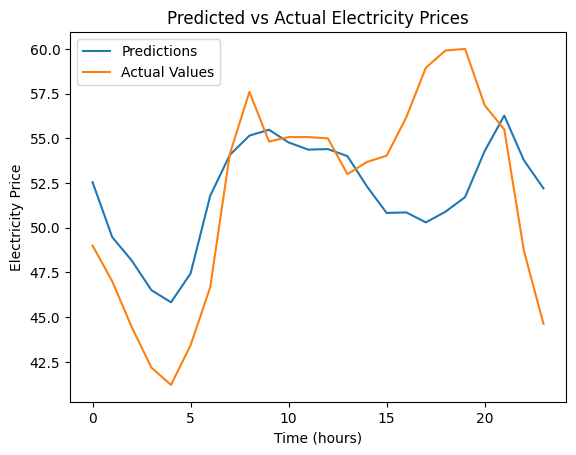

In [21]:
# Create a figure and axes for the plot
fig, ax = plt.subplots()

# Plot the predictions and actual values
ax.plot(predictions[-1], label='Predictions')
ax.plot(y_test[-1], label='Actual Values')

# Add a legend and labels to the plot
ax.legend()
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Electricity Price')
ax.set_title('Predicted vs Actual Electricity Prices')

# Show the plot
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("MSE: ", mse)
print("MAE: ", mae)

MSE:  23.479493113477044
MAE:  4.04857524447971


In [23]:
# Histogram of residuals
def residual_histogram(y_true, y_pred, step):
    # copy of the input lists
    true = y_true[:]
    pred = y_pred[:]
    # empty list to allocate residuals
    residual = []
    if len(true) ==len(pred):
        for cicle in range(len(true)):
            for item in range(len(true[cicle])):
                residual.append(true[cicle][item] - pred[cicle][item])

    minim = min(residual)
    maxim = max(residual)

    bins = int(abs((maxim - minim) / step))

    df = pd.DataFrame(residual)
    hist = df.hist(bins = bins)
    return residual

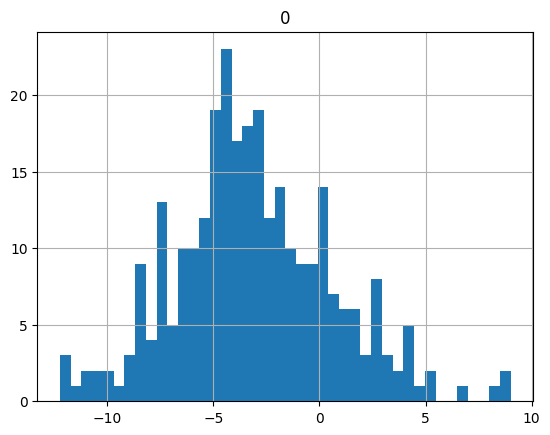

In [24]:
residuals = residual_histogram(y_test, predictions, 0.5)